# Intrinsic Analysis

In [33]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import yaml
import matplotlib.pyplot as plt
import contextily as cx
from src import graph_functions as gf
from src import simplification_functions as sf
from src import evaluation_functions as ef

In [34]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']
    
print('Settings loaded!')

Settings loaded!


**Load OSM graphs and grid:**

In [42]:
# Load simplified and non-simplified graphs

osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
nodes, edges = ox.graph_to_gdfs(osm_graph)
simplified_nodes, simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Measure the length of cycling infrastructure (!=from length of edges)
simplified_edges['infrastructure_length'] = simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

print('Data loaded!')

Data loaded!


**Joining grid cell id to network elements:**

In [54]:
simplified_edges['edge_id'] = simplified_edges.reset_index().index
edges_join = gpd.overlay(simplified_edges, grid, how='intersection')
simplified_nodes['node_id'] = simplified_nodes.index
nodes_join = gpd.overlay(simplified_nodes, grid, how='intersection')


In [ ]:
# Function for doing grid analysis

def run_grid_analysis(grid, edges, nodes, func, args):
    
    pass

## Simplification Outcome

In [57]:
# TODO: Evaluate simplification outcome

## Missing Tags

Based on Girres and Touya, 2010??

In [4]:
print(f'Tags to be analysed are:')
[print(value) for _, value in missing_tag_dict.items()]

missing_tags = ef.analyse_missing_tags(edges, missing_tag_dict)

for key, value in missing_tags.items():
    print(f'In the entire dataset, {value} edges or {value/len(edges)*100:.2f} % are missing information about {key}')

# TODO: Compute on a cell basis!

Tags to be analysed are:
{'true_geometries': ['surface,', 'cycleway_surface'], 'centerline': ['cycleway_surface']}
{'true_geometries': ['width,', 'cycleway_width,', 'cycleway_left_width', "cycleway_right_width'", 'cycleway_both_width'], 'centerline': ['cycleway_width', 'cycleway_left_width', 'cycleway_right_width', 'cycleway_both_width']}
{'all': ['lit']}
In the entire dataset, 29540 edges or 96.36 % are missing information about surface
In the entire dataset, 30008 edges or 97.89 % are missing information about width
In the entire dataset, 6960 edges or 22.70 % are missing information about lit


## Network Topology

### Network Metrics

**Compute network density:**

In [ ]:
# TODO: Compute network (edge and intersection and dangling node) density - per grid cell basis

def compute_gridded_network_density(edges, nodes, area):

    edge_density = edges.infrastructure_length.sum() / area

    node_density = len(nodes)/area

    dangling_nodes = ef.get_dangling_nodes(edges, nodes)

    dangling_node_density = len(dangling_nodes) / area

    return edge_density, node_density, dangling_node_density

**Count and plot all dangling nodes (dead ends):**

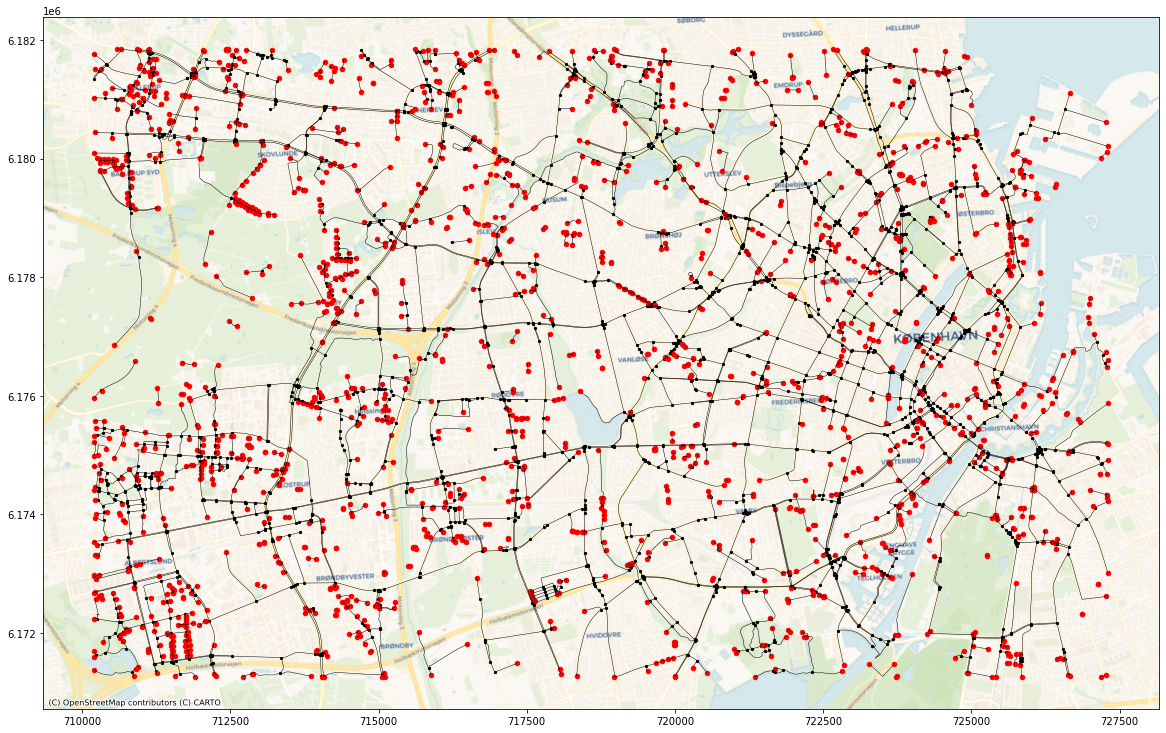

In [7]:
# Compute number of dangling nodes - and plot them
dangling_nodes = ef.get_dangling_nodes(simplified_edges, simplified_nodes)

# TODO: Create Folium plot instead?

fig, ax = plt.subplots(1, figsize=(20,20))

simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
simplified_nodes.plot(ax=ax, color='black', markersize=5)
dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

**Count and plot the number of connected components:**

333 graphs have been generated from the connected components
The network consists of 333 unconnected components.


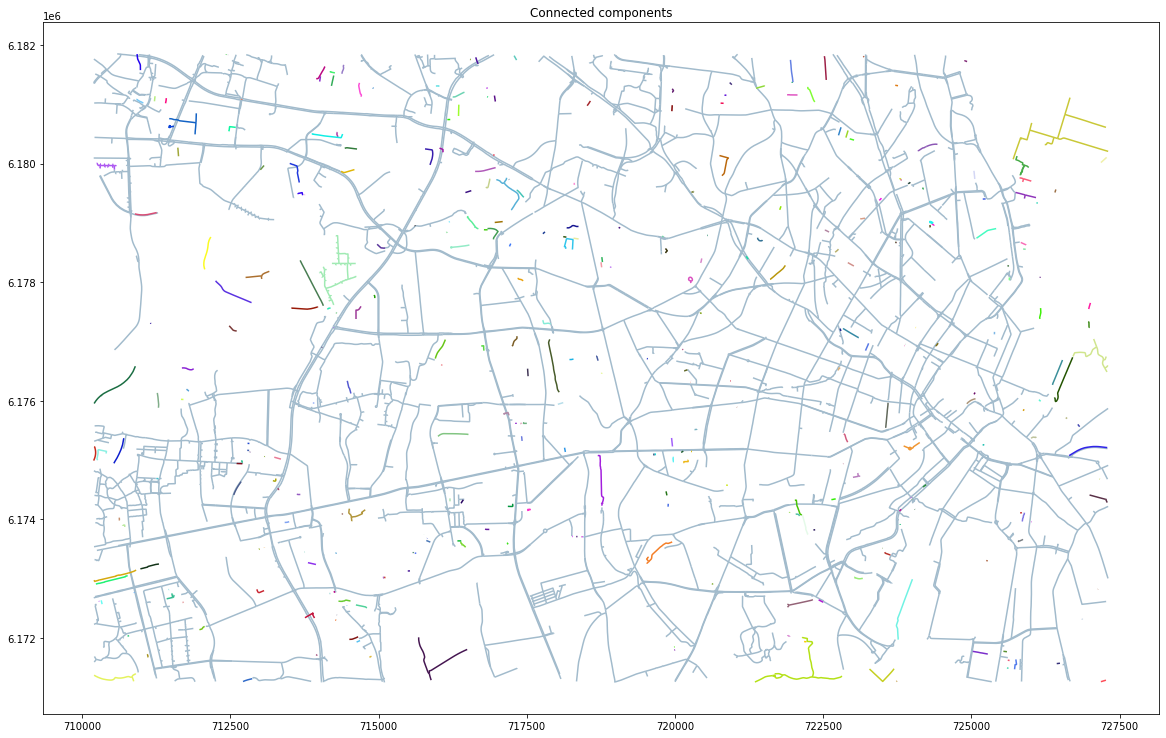

In [9]:
components = ef.return_components(osm_simplified_graph)
print(f'The network in the study area consists of {len(components)} unconnected components.')

components_plot = ef.plot_components(components)

### Signs of topological errors

**Identifying nodes that are placed within a distance of one meter, but do not share a common edge.**

Based on Barron et al., 2013.


In [5]:
buffer_dist = 1
snapping_issues = ef.find_network_gaps(nodes,edges, buffer_dist)

print(f'There are {len(snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

# TODO: Plot a map of the identified problems

There are 2 locations where a node is placed within 1 meters of another node without sharing an edge


**Finding edges that cross each other without a node indicating an intersection, and which are not tagged as either bridge or tunnel:**

Based on Barron et al., 2013.

In [6]:
edges['intersection_issues'] = edges.apply(lambda x: ef.check_intersection(row = x, gdf=edges), axis=1)

count_intersection_issues = len(edges.loc[(edges.intersection_issues.notna()) & edges.intersection_issues > 0])

print(f'{count_intersection_issues} edges appear to be missing an intersection node or a bridge/tunnel tag.')

# TODO: Plot a map of the identified problems

0 edges appear to be missing an intersection node or a bridge/tunnel tag


## Consistency

**Checking for incompatible tags:**

In [59]:

incompatible_tags = ef.check_incompatible_tags(edges, incompatible_tags_dict)

print(f'In the entire dataset there are {sum(incompatible_tags.values())} incompatible tag combinations (of those defined)')

# TODO: Compute on a cell basis!

# TODO: Plot edges with incompatible tags


In the entire dataset there are 8 incompatible tag combinations
